Rosenbrock synthetic function:

GP CBM versus STP nu = 3 CBM (winner)

https://www.sfu.ca/~ssurjano/rosen.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.6 MB/s 
     |████████████████████████████████| 872 kB 51.9 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=bc7fec7a8df6bd5a6912f08674d87aa514bb35ec00f8fb24b931a02eb78c639d
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=7024f0dc8492148231adf04a97f685a0c75626e21c98c2e4f46456332e963550
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Rosenbrock'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util_gp = 'CBMinimized'
util_stp = 'tCBMinimized'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Rosenbrock':
            
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -2.048 
    ub = +2.048 
    
# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))
    
    def f_syn_polarity(x1_training, x2_training):
        return operator * (100 * (x2_training - x1_training ** 2) ** 2 + (x1_training - 1) ** 2)


In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Acquisition function - CBM:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBMinimized': self.CBMinimized,
            'tCBMinimized': self.tCBMinimized
        }

        self.f = mode_dict[mode]
   
    def CBMinimized(self, tau, mean, std):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
    
    def tCBMinimized(self, tau, mean, std, nu=df):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))

    def eval(self, y_global_orig, mean, std):
    
        return self.f(y_global_orig, mean, std, **self.params)
        
    def t_eval(self, y_global_orig, mean, std, nu=df):
    
        return self.f(y_global_orig, mean, std, nu=df, **self.params)
    

In [9]:
n_start_AcqFunc = max_iter
inverse = -1


In [10]:
## GPGO_multi: Gaussian

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
## GPGO_multi_STP: Student's-t

class GPGO_multi_STP(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.t_eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_1 = GPGO_multi(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.33987787  0.90244913]	 63.72149506568065	 2.0636815813193974	    
init	 [-2.04753152 -0.80964578]	 2511.318971868364	 2.0636815813193974	    
init	 [-1.44688787 -1.66978112]	 1422.2040787100386	 2.0636815813193974	    
init	 [-1.28507817 -0.63258326]	 526.8913737894474	 2.0636815813193974	    
init	 [-0.42284043  0.15899334]	 2.0636815813193974	 2.0636815813193974	    
1  	 [0.53899161 0.08416064]	 4.470615252692838	 2.0636815813193974	 -23.9467157018634
2	 [0.47634454 0.13914262]	 1.0444232303580065	 1.0444232303580065	 -12.643974523878956
3	 [0.4588531  0.15374881]	 0.6154339438636984	 0.6154339438636984	 -9.229720085023057
4	 [0.4503864  0.16055302]	 0.48096085292274166	 0.48096085292274166	 -7.469417811460466
5	 [0.44545985 0.16435854]	 0.42363168686665176	 0.42363168686665176	 -6.382828181439051
6	 [0.4422826  0.16672531]	 0.3945037445428108	 0.3945037445428108	 -5.642144270507412
7	 [0.4400

In [13]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_2 = GPGO_multi(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.26216488 -1.94180615]	 405.8187938051167	 10.016400127761926	    
init	 [ 0.20341751 -0.26491948]	 10.016400127761926	 10.016400127761926	    
init	 [-0.32617348 -0.69494857]	 65.97294928625357	 10.016400127761926	    
init	 [-1.20975919  0.48853388]	 99.94230490266065	 10.016400127761926	    
init	 [-0.82061446 -0.95507548]	 268.5105099964258	 10.016400127761926	    
1  	 [1.068739   0.39883889]	 55.26375424728587	 10.016400127761926	 -12.455049369366812
2  	 [2.048 2.048]	 461.7603900415999	 10.016400127761926	 2.3454961941060186
3  	 [ 2.048      -1.00192199]	 2701.1747625500825	 10.016400127761926	 5.951308509397038
4  	 [0.29316116 0.59731317]	 26.64951847051525	 10.016400127761926	 -10.770303957527082
5  	 [-2.048  2.048]	 469.9523900415999	 10.016400127761926	 -0.24355793000490755
6  	 [0.26936951 0.5046551 ]	 19.20444455123678	 10.016400127761926	 3.603697632459909
7  	 [0.27210836 0.4914

In [14]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_3 = GPGO_multi(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.20806821 0.85257348]	 66.12074614607258	 50.941111321262525	    
init	 [-0.85645419  0.04434987]	 50.941111321262525	 50.941111321262525	    
init	 [1.60951073 1.62321649]	 93.94003449768307	 50.941111321262525	    
init	 [-1.53360257 -1.19913317]	 1267.4289626896234	 50.941111321262525	    
init	 [-1.83719034 -0.24244288]	 1316.8330877748904	 50.941111321262525	    
1  	 [ 2.048 -2.048]	 3897.7342268415996	 50.941111321262525	 -2.417312751533327
2  	 [-0.68532544  2.048     ]	 251.95257900027025	 50.941111321262525	 6.465300888568032
3	 [0.22509211 0.51184822]	 21.869344013701106	 21.869344013701106	 22.932032125720866
4	 [0.22586766 0.51082798]	 21.741967862594056	 21.741967862594056	 21.899815228326105
5	 [0.22627408 0.51029359]	 21.67534776601895	 21.67534776601895	 21.355429125769717
6	 [0.22652643 0.5099619 ]	 21.63403060778634	 21.63403060778634	 21.016825666827526
7	 [0.22669935 0.50973465

In [15]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_4 = GPGO_multi(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.91295422 0.19346329]	 1202.1009483415905	 170.66405971002487	    
init	 [1.93611514 0.87988631]	 823.7947602867234	 170.66405971002487	    
init	 [ 0.80989727 -1.16289743]	 330.8507621971172	 170.66405971002487	    
init	 [ 1.95082017 -2.02248087]	 3397.672500714367	 170.66405971002487	    
init	 [-1.01178424 -0.26709388]	 170.66405971002487	 170.66405971002487	    
1  	 [-2.048  2.048]	 469.9523900415999	 170.66405971002487	 0.9369579217390904
2  	 [-2.048 -2.048]	 3905.9262268415996	 170.66405971002487	 5.994477172980807
3	 [-0.48313473  0.38102989]	 4.378581287852691	 4.378581287852691	 37.822196390032545
4  	 [-0.48049929  0.40068844]	 5.075383547589922	 4.378581287852691	 22.641464692243147
5  	 [-0.47960913  0.40882018]	 5.386017736534159	 4.378581287852691	 16.736232077812378
6  	 [-0.47920252  0.41331808]	 5.561985487680732	 4.378581287852691	 13.631447996101883
7  	 [-0.4789862  0.4161941

In [16]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_5 = GPGO_multi(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.13871597  1.51851953]	 9.495646950867519	 9.495646950867519	    
init	 [-1.20127834  1.71463028]	 12.220143873516523	 9.495646950867519	    
init	 [-0.04746777  0.45770286]	 21.840629211931905	 9.495646950867519	    
init	 [1.08915858 0.07544008]	 123.40146376592485	 9.495646950867519	    
init	 [-0.83230515 -1.27909385]	 392.1670023300852	 9.495646950867519	    
1  	 [-0.04348947  2.048     ]	 419.74493774045783	 9.495646950867519	 0.48624183339491667
2  	 [-1.73397303  1.34445711]	 283.76727613875073	 9.495646950867519	 -4.44094535297158
3  	 [-1.05632697 -1.69955139]	 796.8638458519836	 9.495646950867519	 -2.8284275424952865
4  	 [ 2.048 -2.048]	 3897.7342268415996	 9.495646950867519	 -2.8108139666384737
5  	 [2.048     1.3845074]	 790.5939969908841	 9.495646950867519	 18.97241503691896
6  	 [-0.13757396  0.35375544]	 12.505109932249134	 9.495646950867519	 46.73750247211272
7  	 [-0.14924197  

In [17]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_6 = GPGO_multi(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.60915518 -0.68821072]	 1074.6314195925434	 3.0269049669752817	    
init	 [ 1.31575449 -1.87721062]	 1302.169546932896	 3.0269049669752817	    
init	 [-1.60703824  0.38933325]	 487.8262244570432	 3.0269049669752817	    
init	 [ 0.12213192 -0.33256477]	 12.844955340992902	 3.0269049669752817	    
init	 [-0.67416945  0.50183959]	 3.0269049669752817	 3.0269049669752817	    
1  	 [0.2745924  1.64081315]	 245.5777410115649	 3.0269049669752817	 -7.381908563464939
2  	 [-2.048 -2.048]	 3905.9262268415996	 3.0269049669752817	 8.415836598523523
3  	 [2.048 2.048]	 461.7603900415999	 3.0269049669752817	 29.787546995472695
4  	 [-0.16026582  0.39328932]	 14.859500733208346	 3.0269049669752817	 41.604547854506365
5  	 [-0.15584659  0.3971262 ]	 15.23680202352449	 3.0269049669752817	 32.78916310523577
6  	 [-0.15351028  0.39915837]	 15.437593536956385	 3.0269049669752817	 28.19159091667514
7  	 [-0.15206114  0

In [18]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_7 = GPGO_multi(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.73544125  1.14654737]	 355.3830807157107	 74.10242381766855	    
init	 [-0.25227579  0.91531337]	 74.10242381766855	 74.10242381766855	    
init	 [1.95784504 0.15767909]	 1351.8314081149692	 74.10242381766855	    
init	 [ 0.00458942 -1.75287856]	 308.2565501886822	 74.10242381766855	    
init	 [-9.48473938e-01 -4.81276619e-04]	 84.81168700546641	 74.10242381766855	    
1  	 [-2.048 -2.048]	 3905.9262268415996	 74.10242381766855	 15.043235754253846
2  	 [0.09532419 2.048     ]	 416.53518223749626	 74.10242381766855	 35.180935941413225
3  	 [ 2.048 -2.048]	 3897.7342268415996	 74.10242381766855	 60.85321080535045
4	 [-0.4228508   0.21849214]	 2.1820288066569464	 2.1820288066569464	 68.50497974940767
5	 [-0.40465422  0.19940278]	 2.100200950496273	 2.100200950496273	 46.57436035239185
6	 [-0.39489947  0.1890699 ]	 2.055466479493346	 2.055466479493346	 35.13977296877807
7	 [-0.38873395  0.18247924]	 

In [19]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_8 = GPGO_multi(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.52956683 1.91914255]	 17.95675982372887	 1.7663579664225912	    
init	 [1.51222084 0.12638491]	 467.0068292530542	 1.7663579664225912	    
init	 [-1.09474477 -2.0013105 ]	 1028.244988519411	 1.7663579664225912	    
init	 [-0.28479972 -0.39996883]	 24.79447905426233	 1.7663579664225912	    
init	 [ 0.09287545 -0.0885072 ]	 1.7663579664225912	 1.7663579664225912	    
1  	 [-0.55145036  0.84181591]	 31.3211073777646	 1.7663579664225912	 -3.214588514473642
2  	 [-2.048  2.048]	 469.9523900415999	 1.7663579664225912	 -2.7196493014728538
3  	 [ 2.048 -2.048]	 3897.7342268415996	 1.7663579664225912	 -2.1804210468047214
4  	 [-0.36818672  0.3790994 ]	 7.803007972397172	 1.7663579664225912	 -1.8987601825259506
5  	 [-0.36698746  0.37746411]	 7.76307688771208	 1.7663579664225912	 0.19715390418489695
6  	 [-0.36630856  0.37652623]	 7.73987382315488	 1.7663579664225912	 1.3869744632211138
7  	 [-0.36587332  0

In [20]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_9 = GPGO_multi(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    
1  	 [ 1.44056482 -0.0133712 ]	 436.4183386380958	 132.4681822844375	 -5.396019593610753
2  	 [2.048 2.048]	 461.7603900415999	 132.4681822844375	 19.06410215180806
3  	 [ 2.048 -2.048]	 3897.7342268415996	 132.4681822844375	 22.340445359171056
4  	 [-0.31621121  2.048     ]	 381.20689169007954	 132.4681822844375	 35.6189268540735
5  	 [-2.048  2.048]	 469.9523900415999	 132.4681822844375	 123.85265224109278
6	 [0.45736024 0.44866075]	 6.029637838071775	 6.029637838071775	 151.39241931988596
7  	 [0.43809478 0.47386456]	 8.264613961213

In [21]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_10 = GPGO_multi(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.11132935 -1.96300002]	 1022.7666615237944	 26.382363522743674	    
init	 [0.54742317 1.0191007 ]	 51.962573317574716	 26.382363522743674	    
init	 [-0.00611528 -1.12723294]	 128.08610911295406	 26.382363522743674	    
init	 [-1.23673451  1.0671338 ]	 26.382363522743674	 26.382363522743674	    
init	 [-1.35532201 -1.68616012]	 1246.7412252563456	 26.382363522743674	    
1  	 [2.048 2.048]	 461.7603900415999	 26.382363522743674	 -1.7266682871994354
2  	 [-2.048  2.048]	 469.9523900415999	 26.382363522743674	 -0.045235892865256394
3	 [-0.69005673  0.57775149]	 3.888003270765736	 3.888003270765736	 1.4338936715882555
4	 [-0.69139291  0.57869239]	 3.874219279236499	 3.874219279236499	 1.6120661545386954
5	 [-0.69199232  0.57911372]	 3.8680515986031887	 3.8680515986031887	 1.6852418921484924
6	 [-0.69233323  0.57935333]	 3.8645524391887087	 3.8645524391887087	 1.7249599483033704
7	 [-0.6925524   0.579

In [22]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_11 = GPGO_multi(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.30961535 -1.96822941]	 1362.0202619238294	 4.533376036769996	    
init	 [-0.15065692  0.92132937]	 82.0779347186456	 4.533376036769996	    
init	 [-0.32684604 -0.05969061]	 4.533376036769996	 4.533376036769996	    
init	 [-1.99564978 -0.0517259 ]	 1636.5670319859503	 4.533376036769996	    
init	 [1.80964005 1.43685669]	 338.45801473698816	 4.533376036769996	    
1  	 [ 0.67634073 -0.25465146]	 50.811722137458325	 4.533376036769996	 -12.353553946865462
2  	 [ 2.048 -2.048]	 3897.7342268415996	 4.533376036769996	 1.2776098999750825
3  	 [0.33520768 0.32779882]	 5.083156554584719	 4.533376036769996	 0.64360468931524
4  	 [0.33472736 0.32724162]	 5.0736577786244	 4.533376036769996	 1.3530739058629482
5  	 [0.33446264 0.32693444]	 5.068415622667275	 4.533376036769996	 1.7403915370470442
6  	 [0.33429496 0.32673997]	 5.065097566220301	 4.533376036769996	 1.9842963049828315
7  	 [0.33417929 0.32660583]	

In [23]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_12 = GPGO_multi(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.416549    0.98324356]	 110.56781423235984	 68.14456326432247	    
init	 [-0.9694617   0.13819656]	 68.14456326432247	 68.14456326432247	    
init	 [-1.98830095  1.71518775]	 509.86279959563035	 68.14456326432247	    
init	 [ 1.64132804 -1.91110583]	 2121.0723550229873	 68.14456326432247	    
init	 [ 1.87166448 -1.48599062]	 2489.890190157968	 68.14456326432247	    
1  	 [-2.048 -2.048]	 3905.9262268415996	 68.14456326432247	 -0.8395986065430187
2  	 [2.048 2.048]	 461.7603900415999	 68.14456326432247	 -0.7807752852801844
3	 [-0.22135081  0.71993936]	 46.508173181170065	 46.508173181170065	 24.57479432085719
4	 [-0.24455324  0.70206406]	 42.79841688721608	 42.79841688721608	 33.09013887911929
5	 [-0.25073826  0.69752325]	 41.84286205392708	 41.84286205392708	 35.37222330183549
6	 [-0.25347612  0.69555294]	 41.425525067589085	 41.425525067589085	 36.3897859989692
7	 [-0.2549789   0.69448466]	 41.19

In [24]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_13 = GPGO_multi(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.13746907 -1.07503116]	 561.1720108286133	 2.166231627813885	    
init	 [1.32824487 1.90770872]	 2.166231627813885	 2.166231627813885	    
init	 [ 1.93577416 -0.19067188]	 1551.5761879230556	 2.166231627813885	    
init	 [0.44663793 1.1285566 ]	 86.6235326520391	 2.166231627813885	    
init	 [0.58004826 0.90938667]	 33.00131633274188	 2.166231627813885	    
1  	 [0.18878272 2.048     ]	 405.6177874873539	 2.166231627813885	 -19.8822693504938
2  	 [-2.048      -0.35234556]	 2076.4925277623465	 2.166231627813885	 -2.775742934241816
3  	 [2.048 2.048]	 461.7603900415999	 2.166231627813885	 13.130504170596822
4  	 [-2.048  2.048]	 469.9523900415999	 2.166231627813885	 71.7218008281109
5  	 [-0.08590068 -2.048     ]	 423.63743376824124	 2.166231627813885	 78.31437005903713
6  	 [0.26454896 1.12378166]	 111.58938585156567	 2.166231627813885	 107.44425171673456
7  	 [0.26573983 1.12479032]	 111.667138057

In [25]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_14 = GPGO_multi(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.05711194 1.11888405]	 125.35034508047823	 56.7252447162893	    
init	 [ 1.5172718 -2.0150397]	 1864.0489319378007	 56.7252447162893	    
init	 [-0.77932165  1.87434492]	 163.6955655658878	 56.7252447162893	    
init	 [ 0.05372605 -0.744307  ]	 56.7252447162893	 56.7252447162893	    
init	 [ 0.16056294 -1.14173976]	 137.01499974575526	 56.7252447162893	    
1  	 [-1.85845096 -1.21633226]	 2189.2216080838643	 56.7252447162893	 -2.9356235508968576
2  	 [2.048 2.048]	 461.7603900415999	 56.7252447162893	 -1.899411550905565
3  	 [-2.048  2.048]	 469.9523900415999	 56.7252447162893	 16.541956030651413
4	 [0.39324155 0.01356975]	 2.358206812667831	 2.358206812667831	 22.884498640151172
5  	 [0.41634357 0.02776968]	 2.459783896353915	 2.358206812667831	 13.002334689846364
6  	 [0.42698466 0.03359979]	 2.5399948215910517	 2.358206812667831	 9.145268081062007
7  	 [0.43335298 0.03689791]	 2.5980759973309873

In [26]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_15 = GPGO_multi(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.42875729 -1.31524229]	 1126.8532605124637	 56.02298763074632	    
init	 [-1.82532827 -0.56713852]	 1528.1728177033635	 56.02298763074632	    
init	 [-0.9199578   0.12288092]	 56.02298763074632	 56.02298763074632	    
init	 [-0.79495612 -0.80087302]	 208.52154958515655	 56.02298763074632	    
init	 [-1.59030773 -1.02441364]	 1269.4404638957562	 56.02298763074632	    
1	 [-0.25762975  0.46687282]	 17.621636274780048	 17.621636274780048	 -30.233947423217113
2	 [-0.29072975  0.45985612]	 15.753419144176434	 15.753419144176434	 -9.218378535992967
3  	 [-0.90851461  1.30581906]	 26.72279105936442	 15.753419144176434	 -4.003257906984153
4  	 [2.048 2.048]	 461.7603900415999	 15.753419144176434	 -2.817339821116012
5	 [-0.1597922   0.19273671]	 4.140807690309339	 4.140807690309339	 -2.47051947251273
6  	 [-0.16925344  0.211065  ]	 4.69479638016576	 4.140807690309339	 -1.136234753196922
7  	 [-2.048  2.048

In [27]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_16 = GPGO_multi(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.13339974  0.09487705]	 146.09426826423262	 146.09426826423262	    
init	 [ 0.20767317 -1.86121441]	 363.27983894611043	 146.09426826423262	    
init	 [-0.57045469 -1.13426046]	 215.5326110993483	 146.09426826423262	    
init	 [ 0.77302236 -1.37735608]	 390.08228141599125	 146.09426826423262	    
init	 [-1.75994935  1.80638048]	 174.29606237276562	 146.09426826423262	    
1  	 [2.048 2.048]	 461.7603900415999	 146.09426826423262	 -2.5272672156926403
2  	 [-2.048 -2.048]	 3905.9262268415996	 146.09426826423262	 19.70978218180057
3  	 [-0.08545566  2.048     ]	 417.62277319254093	 146.09426826423262	 21.023103660533515
4  	 [ 2.048      -0.07553366]	 1824.2496719115393	 146.09426826423262	 31.92183263509274
5  	 [-2.048      1.0150799]	 1020.0368925168646	 146.09426826423262	 78.59281990460997
6	 [-0.35585822 -0.07476373]	 5.894499581068056	 5.894499581068056	 88.27702833563761
7	 [-0.34212479 -0.06

In [28]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_17 = GPGO_multi(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.84105215  0.12528335]	 37.27181038922863	 0.19652774971866602	    
init	 [-1.26353086 -1.76988013]	 1138.381976578598	 0.19652774971866602	    
init	 [1.17549244 0.64034211]	 55.004181467935105	 0.19652774971866602	    
init	 [0.56328559 0.30966945]	 0.19652774971866602	 0.19652774971866602	    
init	 [-1.8879983  -0.58239548]	 1728.0458971940702	 0.19652774971866602	    
1  	 [-0.19459773  1.10359281]	 115.00394182677012	 0.19652774971866602	 -37.688651243575414
2  	 [ 2.048 -2.048]	 3897.7342268415996	 0.19652774971866602	 -1.0507096534561196
3  	 [2.048 2.048]	 461.7603900415999	 0.19652774971866602	 3.5508197522701597
4  	 [0.17654881 0.53812613]	 26.378576619030238	 0.19652774971866602	 5.107627976148265
5  	 [0.17819172 0.53934496]	 26.44040118783115	 0.19652774971866602	 10.23654596471468
6  	 [0.17917148 0.54002879]	 26.472679303658627	 0.19652774971866602	 13.221179710129991
7  	 [0.1798

In [29]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_18 = GPGO_multi(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.61593289 0.02233702]	 12.895000300241685	 12.895000300241685	    
init	 [ 1.55075162 -1.30318244]	 1375.2393970855524	 12.895000300241685	    
init	 [1.44274665 1.02455823]	 111.91239818238155	 12.895000300241685	    
init	 [0.68035243 1.99841976]	 235.89058418537797	 12.895000300241685	    
init	 [-0.99545734 -1.93205893]	 858.3713873043706	 12.895000300241685	    
1  	 [-2.048       1.41633394]	 781.0020700691645	 12.895000300241685	 -0.6413046822024493
2  	 [0.16140696 0.51196921]	 24.31477178556434	 12.895000300241685	 36.81477848446228
3  	 [0.15311051 0.51192077]	 24.578291529173136	 12.895000300241685	 31.15442965887146
4  	 [0.14957548 0.51188957]	 24.685886137340454	 12.895000300241685	 28.737794650791965
5  	 [0.14761425 0.51186406]	 24.74382288596709	 12.895000300241685	 27.405015618066095
6  	 [0.14636564 0.51184277]	 24.779856589825563	 12.895000300241685	 26.56288812508633
7  	 [0.14

In [30]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_19 = GPGO_multi(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.64850237  1.07007884]	 278.43400025820534	 57.78708636899354	    
init	 [-1.03654206 -1.48221261]	 657.7842496298689	 57.78708636899354	    
init	 [-0.69039488 -1.70803378]	 480.139610337942	 57.78708636899354	    
init	 [0.70441812 1.2558082 ]	 57.78708636899354	 57.78708636899354	    
init	 [1.97731088 0.55566637]	 1125.9484203106679	 57.78708636899354	    
1  	 [0.20063659 2.048     ]	 403.7429634517199	 57.78708636899354	 -3.0499836454381453
2  	 [ 2.048 -2.048]	 3897.7342268415996	 57.78708636899354	 -2.3767835172725045
3  	 [-2.048  2.048]	 469.9523900415999	 57.78708636899354	 85.08488399032329
4	 [-0.22997653  0.56169607]	 27.401285214945457	 27.401285214945457	 108.80963484985388
5	 [-0.24198348  0.53667388]	 24.402193298985456	 24.402193298985456	 71.34503346046853
6	 [-0.2464851   0.52656967]	 23.252064841007627	 23.252064841007627	 56.083915012627706
7	 [-0.24894032  0.52089215]	 22.6

In [31]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_20 = GPGO_multi(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.36098376 1.62903543]	 225.0263501192369	 5.168692520381821	    
init	 [1.60370987 1.29367031]	 163.7478327754951	 5.168692520381821	    
init	 [-1.90099626  0.78543905]	 808.3708592256118	 5.168692520381821	    
init	 [-0.49692286  0.07582083]	 5.168692520381821	 5.168692520381821	    
init	 [ 0.6469692  -1.25398951]	 279.86987688431674	 5.168692520381821	    
1  	 [-2.048 -2.048]	 3905.9262268415996	 5.168692520381821	 -2.4733582603479327
2  	 [ 2.048 -2.048]	 3897.7342268415996	 5.168692520381821	 33.146166273611364
3	 [ 0.05748043 -0.17765216]	 4.162856264630361	 4.162856264630361	 -0.24209405814467766
4	 [ 0.05615846 -0.17758564]	 4.157510466366406	 4.157510466366406	 0.6962975568136334
5	 [ 0.05556928 -0.17755296]	 4.1550628904418705	 4.1550628904418705	 1.1055473151990196
6	 [ 0.05523517 -0.17753338]	 4.153649583459747	 4.153649583459747	 1.3349554573535045
7	 [ 0.05502027 -0.17752035]	 4.15

In [32]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_stp_1 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_1 = GPGO_multi_STP(surrogate_stp_1, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.33987787  0.90244913]	 63.72149506568065	 2.0636815813193974	    
init	 [-2.04753152 -0.80964578]	 2511.318971868364	 2.0636815813193974	    
init	 [-1.44688787 -1.66978112]	 1422.2040787100386	 2.0636815813193974	    
init	 [-1.28507817 -0.63258326]	 526.8913737894474	 2.0636815813193974	    
init	 [-0.42284043  0.15899334]	 2.0636815813193974	 2.0636815813193974	    
1  	 [ 1.51738329 -0.54173311]	 809.2066105048989	 2.0636815813193974	 -1552.7409687648194
2  	 [2.048 2.048]	 461.7603900415999	 2.0636815813193974	 -1486.1297966131474
3  	 [-2.048  2.048]	 469.9523900415999	 2.0636815813193974	 -1401.6989304075798
4  	 [0.09751254 2.048     ]	 416.3591633533755	 2.0636815813193974	 -1252.5038738226287
5  	 [ 2.048 -2.048]	 3897.7342268415996	 2.0636815813193974	 -1170.5501378758452
6	 [0.87414311 0.69601243]	 0.4797883700925253	 0.4797883700925253	 -1788.732650965613
7  	 [2.048     0.7575371]	 

In [33]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_stp_2 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_2 = GPGO_multi_STP(surrogate_stp_2, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.26216488 -1.94180615]	 405.8187938051167	 10.016400127761926	    
init	 [ 0.20341751 -0.26491948]	 10.016400127761926	 10.016400127761926	    
init	 [-0.32617348 -0.69494857]	 65.97294928625357	 10.016400127761926	    
init	 [-1.20975919  0.48853388]	 99.94230490266065	 10.016400127761926	    
init	 [-0.82061446 -0.95507548]	 268.5105099964258	 10.016400127761926	    
1  	 [1.53250028 0.62337903]	 297.9074911713052	 10.016400127761926	 -269.553068934833
2  	 [-2.048  2.048]	 469.9523900415999	 10.016400127761926	 -285.11191517463556
3  	 [ 2.048 -2.048]	 3897.7342268415996	 10.016400127761926	 -345.6841240796331
4  	 [0.31705965 2.048     ]	 379.7315858851201	 10.016400127761926	 -1819.026658991432
5  	 [-2.048 -2.048]	 3905.9262268415996	 10.016400127761926	 -1701.2439291498272
6  	 [2.048 2.048]	 461.7603900415999	 10.016400127761926	 -2253.3709403807575
7  	 [-0.14046663  0.69496077]	 46.89420

In [34]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_stp_3 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_3 = GPGO_multi_STP(surrogate_stp_3, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.20806821 0.85257348]	 66.12074614607258	 50.941111321262525	    
init	 [-0.85645419  0.04434987]	 50.941111321262525	 50.941111321262525	    
init	 [1.60951073 1.62321649]	 93.94003449768307	 50.941111321262525	    
init	 [-1.53360257 -1.19913317]	 1267.4289626896234	 50.941111321262525	    
init	 [-1.83719034 -0.24244288]	 1316.8330877748904	 50.941111321262525	    
1  	 [ 2.048 -2.048]	 3897.7342268415996	 50.941111321262525	 -963.9807909046048
2	 [-1.30328144  2.048     ]	 17.517158416655004	 17.517158416655004	 -2239.9400501814134
3  	 [0.10599113 2.048     ]	 415.6407770228603	 17.517158416655004	 -1988.4608466456395
4  	 [2.048      0.55817512]	 1323.241628746806	 17.517158416655004	 -1855.1396731691448
5  	 [-2.048  2.048]	 469.9523900415999	 17.517158416655004	 -1819.22571132967
6	 [ 0.17397875 -0.26847763]	 9.607242336024736	 9.607242336024736	 -1630.4594863642792
7  	 [2.048 2.048]	 461.

In [35]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_stp_4 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_4 = GPGO_multi_STP(surrogate_stp_4, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.91295422 0.19346329]	 1202.1009483415905	 170.66405971002487	    
init	 [1.93611514 0.87988631]	 823.7947602867234	 170.66405971002487	    
init	 [ 0.80989727 -1.16289743]	 330.8507621971172	 170.66405971002487	    
init	 [ 1.95082017 -2.02248087]	 3397.672500714367	 170.66405971002487	    
init	 [-1.01178424 -0.26709388]	 170.66405971002487	 170.66405971002487	    
1  	 [-2.048  2.048]	 469.9523900415999	 170.66405971002487	 -2079.296920696226
2  	 [-2.048 -2.048]	 3905.9262268415996	 170.66405971002487	 -1932.6549213958554
3  	 [0.04936894 2.048     ]	 419.33637841462206	 170.66405971002487	 -2603.6401315114713
4  	 [-2.048       0.59311849]	 1306.1440139666709	 170.66405971002487	 -2300.7765398525257
5	 [0.03823073 0.0714291 ]	 1.4145454414714849	 1.4145454414714849	 -2224.230090362967
6  	 [2.048 2.048]	 461.7603900415999	 1.4145454414714849	 -2044.9952136269155
7  	 [-0.08488219 -0.71307304]	

In [36]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_stp_5 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_5 = GPGO_multi_STP(surrogate_stp_5, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.13871597  1.51851953]	 9.495646950867519	 9.495646950867519	    
init	 [-1.20127834  1.71463028]	 12.220143873516523	 9.495646950867519	    
init	 [-0.04746777  0.45770286]	 21.840629211931905	 9.495646950867519	    
init	 [1.08915858 0.07544008]	 123.40146376592485	 9.495646950867519	    
init	 [-0.83230515 -1.27909385]	 392.1670023300852	 9.495646950867519	    
1  	 [2.048 2.048]	 461.7603900415999	 9.495646950867519	 -231.39582680446182
2  	 [ 2.048 -2.048]	 3897.7342268415996	 9.495646950867519	 -316.79121479628145
3  	 [-2.048      -0.01171859]	 1778.3529098564009	 9.495646950867519	 -1768.3590269768783
4  	 [0.15687457 2.048     ]	 410.1217185044142	 9.495646950867519	 -1966.965938104215
5  	 [-2.048 -2.048]	 3905.9262268415996	 9.495646950867519	 -1590.6165415860467
6  	 [ 0.16194471 -0.98867583]	 103.70492745849619	 9.495646950867519	 -1991.1797882849844
7  	 [-2.048  2.048]	 469.95239004

In [37]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_stp_6 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_6 = GPGO_multi_STP(surrogate_stp_6, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.60915518 -0.68821072]	 1074.6314195925434	 3.0269049669752817	    
init	 [ 1.31575449 -1.87721062]	 1302.169546932896	 3.0269049669752817	    
init	 [-1.60703824  0.38933325]	 487.8262244570432	 3.0269049669752817	    
init	 [ 0.12213192 -0.33256477]	 12.844955340992902	 3.0269049669752817	    
init	 [-0.67416945  0.50183959]	 3.0269049669752817	 3.0269049669752817	    
1  	 [0.53873458 2.048     ]	 309.1865646188501	 3.0269049669752817	 -936.6949168810753
2  	 [-2.048 -2.048]	 3905.9262268415996	 3.0269049669752817	 -871.0917680237565
3  	 [-2.048  2.048]	 469.9523900415999	 3.0269049669752817	 -2051.421505210939
4  	 [2.048 2.048]	 461.7603900415999	 3.0269049669752817	 -1921.4570146756043
5  	 [0.34575842 0.78185354]	 44.29277728377713	 3.0269049669752817	 -1673.9699655876
6  	 [-0.62523873  2.048     ]	 277.2316627384011	 3.0269049669752817	 -1566.2802236503414
7  	 [2.048      0.81364806]	 1

In [38]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_stp_7 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_7 = GPGO_multi_STP(surrogate_stp_7, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.73544125  1.14654737]	 355.3830807157107	 74.10242381766855	    
init	 [-0.25227579  0.91531337]	 74.10242381766855	 74.10242381766855	    
init	 [1.95784504 0.15767909]	 1351.8314081149692	 74.10242381766855	    
init	 [ 0.00458942 -1.75287856]	 308.2565501886822	 74.10242381766855	    
init	 [-9.48473938e-01 -4.81276619e-04]	 84.81168700546641	 74.10242381766855	    
1  	 [-2.048 -2.048]	 3905.9262268415996	 74.10242381766855	 -804.8568042260224
2  	 [ 2.048 -2.048]	 3897.7342268415996	 74.10242381766855	 -2148.4559621780295
3  	 [0.92018874 2.048     ]	 144.30717174306415	 74.10242381766855	 -2739.0371994177963
4  	 [2.048 2.048]	 461.7603900415999	 74.10242381766855	 -2443.058181375554
5  	 [-0.62525873  2.048     ]	 277.2234397531298	 74.10242381766855	 -2344.2855910157664
6  	 [-2.048  2.048]	 469.9523900415999	 74.10242381766855	 -2129.9020442108567
7	 [ 0.04040845 -0.24878089]	 7.19151963

In [39]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_stp_8 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_8 = GPGO_multi_STP(surrogate_stp_8, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.52956683 1.91914255]	 17.95675982372887	 1.7663579664225912	    
init	 [1.51222084 0.12638491]	 467.0068292530542	 1.7663579664225912	    
init	 [-1.09474477 -2.0013105 ]	 1028.244988519411	 1.7663579664225912	    
init	 [-0.28479972 -0.39996883]	 24.79447905426233	 1.7663579664225912	    
init	 [ 0.09287545 -0.0885072 ]	 1.7663579664225912	 1.7663579664225912	    
1  	 [-1.1236791   1.16939324]	 5.3797832103068295	 1.7663579664225912	 -655.1185922477978
2  	 [ 2.048 -2.048]	 3897.7342268415996	 1.7663579664225912	 -597.7247481890984
3  	 [-2.048  2.048]	 469.9523900415999	 1.7663579664225912	 -1966.9766169637246
4  	 [0.09237662 2.048     ]	 416.76616510015293	 1.7663579664225912	 -1851.5861156655903
5  	 [-2.048      -0.00507712]	 1772.770484405034	 1.7663579664225912	 -1759.7695355777312
6  	 [2.048 2.048]	 461.7603900415999	 1.7663579664225912	 -1695.331122315411
7  	 [0.14215147 0.79807553]	 

In [40]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_stp_9 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_9 = GPGO_multi_STP(surrogate_stp_9, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    
1	 [0.87794992 0.23986927]	 28.20322180074746	 28.20322180074746	 -1099.4051125756487
2  	 [2.048 2.048]	 461.7603900415999	 28.20322180074746	 -955.5956681163798
3  	 [ 2.048 -2.048]	 3897.7342268415996	 28.20322180074746	 -893.7730713984758
4  	 [-0.32738821  2.048     ]	 378.43900589685836	 28.20322180074746	 -2011.042055954084
5  	 [-2.048  2.048]	 469.9523900415999	 28.20322180074746	 -1804.6307888665663
6  	 [2.048      0.50931505]	 1359.0126624507325	 28.20322180074746	 -1310.2445012735423
7  	 [0.04413644 0.54813922]	 30.746156

In [41]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_stp_10 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_10 = GPGO_multi_STP(surrogate_stp_10, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.11132935 -1.96300002]	 1022.7666615237944	 26.382363522743674	    
init	 [0.54742317 1.0191007 ]	 51.962573317574716	 26.382363522743674	    
init	 [-0.00611528 -1.12723294]	 128.08610911295406	 26.382363522743674	    
init	 [-1.23673451  1.0671338 ]	 26.382363522743674	 26.382363522743674	    
init	 [-1.35532201 -1.68616012]	 1246.7412252563456	 26.382363522743674	    
1  	 [2.048 2.048]	 461.7603900415999	 26.382363522743674	 -929.0159277562763
2  	 [-2.048  2.048]	 469.9523900415999	 26.382363522743674	 -873.2626718761123
3  	 [2.048      0.06588695]	 1705.4810411787535	 26.382363522743674	 -799.0438446457537
4  	 [-0.07550935  2.048     ]	 418.2549707977317	 26.382363522743674	 -1069.9586116920088
5	 [-0.46300621  0.25703928]	 2.322413379492128	 2.322413379492128	 -990.8668635225645
6  	 [-2.048       0.29809637]	 1527.3336929588086	 2.322413379492128	 -915.7643937068345
7  	 [-0.0765811   0.

In [42]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_stp_11 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_11 = GPGO_multi_STP(surrogate_stp_11, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.30961535 -1.96822941]	 1362.0202619238294	 4.533376036769996	    
init	 [-0.15065692  0.92132937]	 82.0779347186456	 4.533376036769996	    
init	 [-0.32684604 -0.05969061]	 4.533376036769996	 4.533376036769996	    
init	 [-1.99564978 -0.0517259 ]	 1636.5670319859503	 4.533376036769996	    
init	 [1.80964005 1.43685669]	 338.45801473698816	 4.533376036769996	    
1  	 [ 2.048      -1.71922578]	 3498.0817449133847	 4.533376036769996	 -1217.0207089117823
2  	 [-2.048  2.048]	 469.9523900415999	 4.533376036769996	 -2091.486718005264
3  	 [0.19697475 2.048     ]	 404.33369447064393	 4.533376036769996	 -1918.5319352868148
4  	 [0.72616771 0.30168093]	 5.166262246476656	 4.533376036769996	 -1702.4276435559318
5  	 [2.048 2.048]	 461.7603900415999	 4.533376036769996	 -1530.9955561406844
6	 [0.34162801 0.09158441]	 0.49658166924182034	 0.49658166924182034	 -1440.9075412914065
7  	 [2.048     0.3594452]	 1

In [43]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_stp_12 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_12 = GPGO_multi_STP(surrogate_stp_12, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.416549    0.98324356]	 110.56781423235984	 68.14456326432247	    
init	 [-0.9694617   0.13819656]	 68.14456326432247	 68.14456326432247	    
init	 [-1.98830095  1.71518775]	 509.86279959563035	 68.14456326432247	    
init	 [ 1.64132804 -1.91110583]	 2121.0723550229873	 68.14456326432247	    
init	 [ 1.87166448 -1.48599062]	 2489.890190157968	 68.14456326432247	    
1  	 [0.79479057 2.048     ]	 200.63493007732734	 68.14456326432247	 -1487.7425568798142
2  	 [-2.048 -2.048]	 3905.9262268415996	 68.14456326432247	 -1366.290131423508
3  	 [2.048      1.11714917]	 947.9864870800825	 68.14456326432247	 -2079.8659990064652
4	 [0.05629848 0.67833266]	 46.47509946444127	 46.47509946444127	 -2102.6090942954925
5  	 [-0.53289644  2.048     ]	 313.52691452931003	 46.47509946444127	 -1603.9921506396063
6  	 [-2.048       0.23012136]	 1580.764707803714	 46.47509946444127	 -1192.742958233962
7  	 [-0.00869619 

In [44]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_stp_13 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_13 = GPGO_multi_STP(surrogate_stp_13, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.13746907 -1.07503116]	 561.1720108286133	 2.166231627813885	    
init	 [1.32824487 1.90770872]	 2.166231627813885	 2.166231627813885	    
init	 [ 1.93577416 -0.19067188]	 1551.5761879230556	 2.166231627813885	    
init	 [0.44663793 1.1285566 ]	 86.6235326520391	 2.166231627813885	    
init	 [0.58004826 0.90938667]	 33.00131633274188	 2.166231627813885	    
1  	 [-1.74994294  0.98398156]	 439.5030656010954	 2.166231627813885	 -907.8196894870987
2  	 [-2.048 -2.048]	 3905.9262268415996	 2.166231627813885	 -869.6114895257958
3  	 [-2.048  2.048]	 469.9523900415999	 2.166231627813885	 -1921.1271050108553
4  	 [-0.31253042 -0.24659288]	 13.574791767330812	 2.166231627813885	 -1699.523971257695
5  	 [ 2.048 -2.048]	 3897.7342268415996	 2.166231627813885	 -1499.1196148029508
6  	 [-0.22215816  2.048     ]	 400.95215431206	 2.166231627813885	 -2263.090037081637
7  	 [2.048 2.048]	 461.7603900415999	 2.16

In [45]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_stp_14 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_14 = GPGO_multi_STP(surrogate_stp_14, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.05711194 1.11888405]	 125.35034508047823	 56.7252447162893	    
init	 [ 1.5172718 -2.0150397]	 1864.0489319378007	 56.7252447162893	    
init	 [-0.77932165  1.87434492]	 163.6955655658878	 56.7252447162893	    
init	 [ 0.05372605 -0.744307  ]	 56.7252447162893	 56.7252447162893	    
init	 [ 0.16056294 -1.14173976]	 137.01499974575526	 56.7252447162893	    
1  	 [-1.93542971 -1.24521455]	 2499.72738326721	 56.7252447162893	 -1087.584609092136
2  	 [2.048 2.048]	 461.7603900415999	 56.7252447162893	 -1668.3136821784783
3  	 [-2.048  2.048]	 469.9523900415999	 56.7252447162893	 -1518.4937482122805
4  	 [2.048      0.29096646]	 1524.7026989382189	 56.7252447162893	 -1401.4756328739104
5  	 [0.41196327 2.048     ]	 353.1417152121608	 56.7252447162893	 -1349.3277290359952
6	 [-0.40400025  0.35536151]	 5.663198342567291	 5.663198342567291	 -1270.637867483825
7  	 [-2.048       0.81279747]	 1152.748944316

In [46]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_stp_15 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_15 = GPGO_multi_STP(surrogate_stp_15, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.42875729 -1.31524229]	 1126.8532605124637	 56.02298763074632	    
init	 [-1.82532827 -0.56713852]	 1528.1728177033635	 56.02298763074632	    
init	 [-0.9199578   0.12288092]	 56.02298763074632	 56.02298763074632	    
init	 [-0.79495612 -0.80087302]	 208.52154958515655	 56.02298763074632	    
init	 [-1.59030773 -1.02441364]	 1269.4404638957562	 56.02298763074632	    
1  	 [0.02850623 1.03742345]	 108.40000384762666	 56.02298763074632	 -1202.9411984814076
2  	 [2.048 2.048]	 461.7603900415999	 56.02298763074632	 -1101.19231355516
3  	 [-1.97367496  2.048     ]	 350.1287822414981	 56.02298763074632	 -1033.1066997379478
4	 [ 0.04631253 -0.18605483]	 4.45143179331232	 4.45143179331232	 -921.006538786642
5  	 [-0.35349846 -2.048     ]	 474.007979961886	 4.45143179331232	 -852.8139577082122
6  	 [2.048      0.48612072]	 1376.1606258985082	 4.45143179331232	 -667.3316231035087
7  	 [-0.46026302  2.048   

In [47]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_stp_16 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_16 = GPGO_multi_STP(surrogate_stp_16, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.13339974  0.09487705]	 146.09426826423262	 146.09426826423262	    
init	 [ 0.20767317 -1.86121441]	 363.27983894611043	 146.09426826423262	    
init	 [-0.57045469 -1.13426046]	 215.5326110993483	 146.09426826423262	    
init	 [ 0.77302236 -1.37735608]	 390.08228141599125	 146.09426826423262	    
init	 [-1.75994935  1.80638048]	 174.29606237276562	 146.09426826423262	    
1  	 [2.048 2.048]	 461.7603900415999	 146.09426826423262	 -258.8653045486227
2  	 [-2.048 -2.048]	 3905.9262268415996	 146.09426826423262	 -316.5340912742543
3	 [0.33356149 0.85937401]	 56.41110821889391	 56.41110821889391	 -1922.0192670029473
4  	 [ 2.048      -0.08629833]	 1833.4539316519836	 56.41110821889391	 -1794.6063117003919
5  	 [-0.15698126  2.048     ]	 410.7359141945132	 56.41110821889391	 -1855.3675637751367
6  	 [ 2.048 -2.048]	 3897.7342268415996	 56.41110821889391	 -1650.5010748308898
7  	 [-2.048       0.7022301

In [48]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_stp_17 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_17 = GPGO_multi_STP(surrogate_stp_17, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.84105215  0.12528335]	 37.27181038922863	 0.19652774971866602	    
init	 [-1.26353086 -1.76988013]	 1138.381976578598	 0.19652774971866602	    
init	 [1.17549244 0.64034211]	 55.004181467935105	 0.19652774971866602	    
init	 [0.56328559 0.30966945]	 0.19652774971866602	 0.19652774971866602	    
init	 [-1.8879983  -0.58239548]	 1728.0458971940702	 0.19652774971866602	    
1  	 [-0.58900297  1.92206085]	 250.63038304827614	 0.19652774971866602	 -1135.4939296805408
2  	 [ 2.048 -2.048]	 3897.7342268415996	 0.19652774971866602	 -1048.1707873955927
3  	 [2.048 2.048]	 461.7603900415999	 0.19652774971866602	 -2155.822206488117
4  	 [-2.048  2.048]	 469.9523900415999	 0.19652774971866602	 -1980.7478292344906
5  	 [0.57124458 2.048     ]	 296.60190515366116	 0.19652774971866602	 -1742.5885398826367
6  	 [2.048      0.49989722]	 1365.9624472419332	 0.19652774971866602	 -1625.956510239665
7  	 [-0.1051479

In [49]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_stp_18 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_18 = GPGO_multi_STP(surrogate_stp_18, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.61593289 0.02233702]	 12.895000300241685	 12.895000300241685	    
init	 [ 1.55075162 -1.30318244]	 1375.2393970855524	 12.895000300241685	    
init	 [1.44274665 1.02455823]	 111.91239818238155	 12.895000300241685	    
init	 [0.68035243 1.99841976]	 235.89058418537797	 12.895000300241685	    
init	 [-0.99545734 -1.93205893]	 858.3713873043706	 12.895000300241685	    
1  	 [-2.048       1.41357535]	 782.5354854385932	 12.895000300241685	 -944.8345892793026
2  	 [2.048 2.048]	 461.7603900415999	 12.895000300241685	 -873.6255180931404
3  	 [-0.19226628  0.56320148]	 29.11384266611476	 12.895000300241685	 -833.2475776046449
4  	 [-2.048      -0.47753798]	 2191.901056565854	 12.895000300241685	 -724.3620549551831
5  	 [-0.47227648  2.048     ]	 335.2136466042439	 12.895000300241685	 -1070.7283387465138
6  	 [0.46890798 0.73041335]	 26.34703070424891	 12.895000300241685	 -974.6017563933003
7  	 [2.048   

In [50]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_stp_19 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_19 = GPGO_multi_STP(surrogate_stp_19, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.64850237  1.07007884]	 278.43400025820534	 57.78708636899354	    
init	 [-1.03654206 -1.48221261]	 657.7842496298689	 57.78708636899354	    
init	 [-0.69039488 -1.70803378]	 480.139610337942	 57.78708636899354	    
init	 [0.70441812 1.2558082 ]	 57.78708636899354	 57.78708636899354	    
init	 [1.97731088 0.55566637]	 1125.9484203106679	 57.78708636899354	    
1  	 [ 2.048 -2.048]	 3897.7342268415996	 57.78708636899354	 -766.5182829381761
2  	 [-0.3570827  2.048    ]	 370.67060470090644	 57.78708636899354	 -2107.988903036291
3	 [-0.24529347  0.19276381]	 3.308897199534992	 3.308897199534992	 -1860.01366471559
4  	 [-2.048  2.048]	 469.9523900415999	 3.308897199534992	 -1743.999028294289
5  	 [-2.048      -0.24899711]	 1983.5827830954668	 3.308897199534992	 -1673.1164082437258
6  	 [2.048 2.048]	 461.7603900415999	 3.308897199534992	 -1741.510308858931
7  	 [-2.048 -2.048]	 3905.9262268415996	 3.30

In [51]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_stp_20 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_20 = GPGO_multi_STP(surrogate_stp_20, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.36098376 1.62903543]	 225.0263501192369	 5.168692520381821	    
init	 [1.60370987 1.29367031]	 163.7478327754951	 5.168692520381821	    
init	 [-1.90099626  0.78543905]	 808.3708592256118	 5.168692520381821	    
init	 [-0.49692286  0.07582083]	 5.168692520381821	 5.168692520381821	    
init	 [ 0.6469692  -1.25398951]	 279.86987688431674	 5.168692520381821	    
1  	 [-2.048 -2.048]	 3905.9262268415996	 5.168692520381821	 -516.4665241235563
2  	 [ 2.048 -2.048]	 3897.7342268415996	 5.168692520381821	 -2082.9052221474
3  	 [0.75407622 0.14431858]	 18.064577175244544	 5.168692520381821	 -2573.329245728223
4  	 [-1.02861759  2.048     ]	 102.11456833359439	 5.168692520381821	 -2413.8187706361546
5  	 [2.048 2.048]	 461.7603900415999	 5.168692520381821	 -2281.8118046362697
6  	 [2.048      0.33002435]	 1494.3640230818949	 5.168692520381821	 -2104.995010993416
7  	 [-2.048  2.048]	 469.9523900415999	 5.1

In [52]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.max(gp_1.GP.y[0:n_init]),gp_1.GP.y[n_init:(n_init+max_iter)]) 
stp_output_1 = np.append(np.max(stp_1.GP.y[0:n_init]),stp_1.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_1 = np.log(y_global_orig - gp_output_1)
regret_stp_1 = np.log(y_global_orig - stp_output_1)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(-1.0422545659592533, -0.7344101679438335)

In [53]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.max(gp_2.GP.y[0:n_init]),gp_2.GP.y[n_init:(n_init+max_iter)]) 
stp_output_2 = np.append(np.max(stp_2.GP.y[0:n_init]),stp_2.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_2 = np.log(y_global_orig - gp_output_2)
regret_stp_2 = np.log(y_global_orig - stp_output_2)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(1.696093584191667, 0.36930092369322676)

In [54]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.max(gp_3.GP.y[0:n_init]),gp_3.GP.y[n_init:(n_init+max_iter)]) 
stp_output_3 = np.append(np.max(stp_3.GP.y[0:n_init]),stp_3.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_3 = np.log(y_global_orig - gp_output_3)
regret_stp_3 = np.log(y_global_orig - stp_output_3)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3


(3.0680924977395394, 0.242363195656135)

In [55]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.max(gp_4.GP.y[0:n_init]),gp_4.GP.y[n_init:(n_init+max_iter)]) 
stp_output_4 = np.append(np.max(stp_4.GP.y[0:n_init]),stp_4.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_4 = np.log(y_global_orig - gp_output_4)
regret_stp_4 = np.log(y_global_orig - stp_output_4)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4


(1.4767247650362427, -1.0417854340553183)

In [56]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.max(gp_5.GP.y[0:n_init]),gp_5.GP.y[n_init:(n_init+max_iter)]) 
stp_output_5 = np.append(np.max(stp_5.GP.y[0:n_init]),stp_5.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_5 = np.log(y_global_orig - gp_output_5)
regret_stp_5 = np.log(y_global_orig - stp_output_5)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5


(2.250833477895446, -0.04765313650548759)

In [57]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.max(gp_6.GP.y[0:n_init]),gp_6.GP.y[n_init:(n_init+max_iter)]) 
stp_output_6 = np.append(np.max(stp_6.GP.y[0:n_init]),stp_6.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_6 = np.log(y_global_orig - gp_output_6)
regret_stp_6 = np.log(y_global_orig - stp_output_6)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6


(1.107540634427908, 1.107540634427908)

In [58]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.max(gp_7.GP.y[0:n_init]),gp_7.GP.y[n_init:(n_init+max_iter)]) 
stp_output_7 = np.append(np.max(stp_7.GP.y[0:n_init]),stp_7.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_7 = np.log(y_global_orig - gp_output_7)
regret_stp_7 = np.log(y_global_orig - stp_output_7)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7


(0.6582709217876653, 0.30414138240672295)

In [59]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.max(gp_8.GP.y[0:n_init]),gp_8.GP.y[n_init:(n_init+max_iter)]) 
stp_output_8 = np.append(np.max(stp_8.GP.y[0:n_init]),stp_8.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_8 = np.log(y_global_orig - gp_output_8)
regret_stp_8 = np.log(y_global_orig - stp_output_8)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8


(0.5689197806346428, 0.5689197806346428)

In [60]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.max(gp_9.GP.y[0:n_init]),gp_9.GP.y[n_init:(n_init+max_iter)]) 
stp_output_9 = np.append(np.max(stp_9.GP.y[0:n_init]),stp_9.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_9 = np.log(y_global_orig - gp_output_9)
regret_stp_9 = np.log(y_global_orig - stp_output_9)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9


(1.7966869489141541, -0.5317596387222013)

In [61]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.max(gp_10.GP.y[0:n_init]),gp_10.GP.y[n_init:(n_init+max_iter)]) 
stp_output_10 = np.append(np.max(stp_10.GP.y[0:n_init]),stp_10.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_10 = np.log(y_global_orig - gp_output_10)
regret_stp_10 = np.log(y_global_orig - stp_output_10)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10


(1.3494395528775378, -3.2356633674598587)

In [62]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.max(gp_11.GP.y[0:n_init]),gp_11.GP.y[n_init:(n_init+max_iter)]) 
stp_output_11 = np.append(np.max(stp_11.GP.y[0:n_init]),stp_11.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_11 = np.log(y_global_orig - gp_output_11)
regret_stp_11 = np.log(y_global_orig - stp_output_11)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11


(1.5114669239052643, -2.5655833416305853)

In [63]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.max(gp_12.GP.y[0:n_init]),gp_12.GP.y[n_init:(n_init+max_iter)]) 
stp_output_12 = np.append(np.max(stp_12.GP.y[0:n_init]),stp_12.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_12 = np.log(y_global_orig - gp_output_12)
regret_stp_12 = np.log(y_global_orig - stp_output_12)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12


(3.705596875841175, -0.36148070384108144)

In [64]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.max(gp_13.GP.y[0:n_init]),gp_13.GP.y[n_init:(n_init+max_iter)]) 
stp_output_13 = np.append(np.max(stp_13.GP.y[0:n_init]),stp_13.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_13 = np.log(y_global_orig - gp_output_13)
regret_stp_13 = np.log(y_global_orig - stp_output_13)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13


(0.7729890809102185, 0.7729890809102185)

In [65]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.max(gp_14.GP.y[0:n_init]),gp_14.GP.y[n_init:(n_init+max_iter)]) 
stp_output_14 = np.append(np.max(stp_14.GP.y[0:n_init]),stp_14.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_14 = np.log(y_global_orig - gp_output_14)
regret_stp_14 = np.log(y_global_orig - stp_output_14)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14


(0.8579015050833391, -0.27552632452668885)

In [66]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.max(gp_15.GP.y[0:n_init]),gp_15.GP.y[n_init:(n_init+max_iter)]) 
stp_output_15 = np.append(np.max(stp_15.GP.y[0:n_init]),stp_15.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_15 = np.log(y_global_orig - gp_output_15)
regret_stp_15 = np.log(y_global_orig - stp_output_15)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15


(1.3186074160403272, 0.6609965805413534)

In [67]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.max(gp_16.GP.y[0:n_init]),gp_16.GP.y[n_init:(n_init+max_iter)]) 
stp_output_16 = np.append(np.max(stp_16.GP.y[0:n_init]),stp_16.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_16 = np.log(y_global_orig - gp_output_16)
regret_stp_16 = np.log(y_global_orig - stp_output_16)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16


(1.4702369332426803, 1.4670225501386023)

In [68]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.max(gp_17.GP.y[0:n_init]),gp_17.GP.y[n_init:(n_init+max_iter)]) 
stp_output_17 = np.append(np.max(stp_17.GP.y[0:n_init]),stp_17.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_17 = np.log(y_global_orig - gp_output_17)
regret_stp_17 = np.log(y_global_orig - stp_output_17)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17


(-1.6269516377010977, -1.6269516377010977)

In [69]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.max(gp_18.GP.y[0:n_init]),gp_18.GP.y[n_init:(n_init+max_iter)]) 
stp_output_18 = np.append(np.max(stp_18.GP.y[0:n_init]),stp_18.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_18 = np.log(y_global_orig - gp_output_18)
regret_stp_18 = np.log(y_global_orig - stp_output_18)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18


(2.556839662616882, 0.37118520786564985)

In [70]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.max(gp_19.GP.y[0:n_init]),gp_19.GP.y[n_init:(n_init+max_iter)]) 
stp_output_19 = np.append(np.max(stp_19.GP.y[0:n_init]),stp_19.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_19 = np.log(y_global_orig - gp_output_19)
regret_stp_19 = np.log(y_global_orig - stp_output_19)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19


(3.034975901757044, 0.7341953226349114)

In [71]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.max(gp_20.GP.y[0:n_init]),gp_20.GP.y[n_init:(n_init+max_iter)]) 
stp_output_20 = np.append(np.max(stp_20.GP.y[0:n_init]),stp_20.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_20 = np.log(y_global_orig - gp_output_20)
regret_stp_20 = np.log(y_global_orig - stp_output_20)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20


(1.4230270424994078, 0.02867775849100804)

In [72]:
# Iteration1 :

slice1 = 0

gp1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

stp1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp1 = np.asarray(gp1_results[4:5][0])[0]
median_gp1 = np.asarray(gp1_results[9:10][0])[0]
upper_gp1 = np.asarray(gp1_results[14:15][0])[0]

lower_stp1 = np.asarray(stp1_results[4:5][0])[0]
median_stp1 = np.asarray(stp1_results[9:10][0])[0]
upper_stp1 = np.asarray(stp1_results[14:15][0])[0]


In [73]:
# Iteration11 :

slice11 = 10

gp11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

stp11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp11 = np.asarray(gp11_results[4:5][0])[0]
median_gp11 = np.asarray(gp11_results[9:10][0])[0]
upper_gp11 = np.asarray(gp11_results[14:15][0])[0]

lower_stp11 = np.asarray(stp11_results[4:5][0])[0]
median_stp11 = np.asarray(stp11_results[9:10][0])[0]
upper_stp11 = np.asarray(stp11_results[14:15][0])[0]


In [74]:
# Iteration21 :

slice21 = 20

gp21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

stp21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp21 = np.asarray(gp21_results[4:5][0])[0]
median_gp21 = np.asarray(gp21_results[9:10][0])[0]
upper_gp21 = np.asarray(gp21_results[14:15][0])[0]

lower_stp21 = np.asarray(stp21_results[4:5][0])[0]
median_stp21 = np.asarray(stp21_results[9:10][0])[0]
upper_stp21 = np.asarray(stp21_results[14:15][0])[0]


In [75]:
# Iteration2 :

slice2 = 1

gp2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

stp2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp2 = np.asarray(gp2_results[4:5][0])[0]
median_gp2 = np.asarray(gp2_results[9:10][0])[0]
upper_gp2 = np.asarray(gp2_results[14:15][0])[0]

lower_stp2 = np.asarray(stp2_results[4:5][0])[0]
median_stp2 = np.asarray(stp2_results[9:10][0])[0]
upper_stp2 = np.asarray(stp2_results[14:15][0])[0]


In [76]:
# Iteration12 :

slice12 = 11

gp12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

stp12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp12 = np.asarray(gp12_results[4:5][0])[0]
median_gp12 = np.asarray(gp12_results[9:10][0])[0]
upper_gp12 = np.asarray(gp12_results[14:15][0])[0]

lower_stp12 = np.asarray(stp12_results[4:5][0])[0]
median_stp12 = np.asarray(stp12_results[9:10][0])[0]
upper_stp12 = np.asarray(stp12_results[14:15][0])[0]


In [77]:
# Iteration3 :

slice3 = 2

gp3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

stp3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp3 = np.asarray(gp3_results[4:5][0])[0]
median_gp3 = np.asarray(gp3_results[9:10][0])[0]
upper_gp3 = np.asarray(gp3_results[14:15][0])[0]

lower_stp3 = np.asarray(stp3_results[4:5][0])[0]
median_stp3 = np.asarray(stp3_results[9:10][0])[0]
upper_stp3 = np.asarray(stp3_results[14:15][0])[0]


In [78]:
# Iteration13 :

slice13 = 12

gp13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

stp13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp13 = np.asarray(gp13_results[4:5][0])[0]
median_gp13 = np.asarray(gp13_results[9:10][0])[0]
upper_gp13 = np.asarray(gp13_results[14:15][0])[0]

lower_stp13 = np.asarray(stp13_results[4:5][0])[0]
median_stp13 = np.asarray(stp13_results[9:10][0])[0]
upper_stp13 = np.asarray(stp13_results[14:15][0])[0]


In [79]:
# Iteration4 :

slice4 = 3

gp4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

stp4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp4 = np.asarray(gp4_results[4:5][0])[0]
median_gp4 = np.asarray(gp4_results[9:10][0])[0]
upper_gp4 = np.asarray(gp4_results[14:15][0])[0]

lower_stp4 = np.asarray(stp4_results[4:5][0])[0]
median_stp4 = np.asarray(stp4_results[9:10][0])[0]
upper_stp4 = np.asarray(stp4_results[14:15][0])[0]


In [80]:
# Iteration14 :

slice14 = 13

gp14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

stp14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp14 = np.asarray(gp14_results[4:5][0])[0]
median_gp14 = np.asarray(gp14_results[9:10][0])[0]
upper_gp14 = np.asarray(gp14_results[14:15][0])[0]

lower_stp14 = np.asarray(stp14_results[4:5][0])[0]
median_stp14 = np.asarray(stp14_results[9:10][0])[0]
upper_stp14 = np.asarray(stp14_results[14:15][0])[0]


In [81]:
# Iteration5 :

slice5 = 4

gp5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

stp5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp5 = np.asarray(gp5_results[4:5][0])[0]
median_gp5 = np.asarray(gp5_results[9:10][0])[0]
upper_gp5 = np.asarray(gp5_results[14:15][0])[0]

lower_stp5 = np.asarray(stp5_results[4:5][0])[0]
median_stp5 = np.asarray(stp5_results[9:10][0])[0]
upper_stp5 = np.asarray(stp5_results[14:15][0])[0]


In [82]:
# Iteration15 :

slice15 = 14

gp15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

stp15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp15 = np.asarray(gp15_results[4:5][0])[0]
median_gp15 = np.asarray(gp15_results[9:10][0])[0]
upper_gp15 = np.asarray(gp15_results[14:15][0])[0]

lower_stp15 = np.asarray(stp15_results[4:5][0])[0]
median_stp15 = np.asarray(stp15_results[9:10][0])[0]
upper_stp15 = np.asarray(stp15_results[14:15][0])[0]


In [83]:
# Iteration6 :

slice6 = 5

gp6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

stp6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp6 = np.asarray(gp6_results[4:5][0])[0]
median_gp6 = np.asarray(gp6_results[9:10][0])[0]
upper_gp6 = np.asarray(gp6_results[14:15][0])[0]

lower_stp6 = np.asarray(stp6_results[4:5][0])[0]
median_stp6 = np.asarray(stp6_results[9:10][0])[0]
upper_stp6 = np.asarray(stp6_results[14:15][0])[0]


In [84]:
# Iteration16 :

slice16 = 15

gp16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

stp16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp16 = np.asarray(gp16_results[4:5][0])[0]
median_gp16 = np.asarray(gp16_results[9:10][0])[0]
upper_gp16 = np.asarray(gp16_results[14:15][0])[0]

lower_stp16 = np.asarray(stp16_results[4:5][0])[0]
median_stp16 = np.asarray(stp16_results[9:10][0])[0]
upper_stp16 = np.asarray(stp16_results[14:15][0])[0]


In [85]:
# Iteration7 :

slice7 = 6

gp7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

stp7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp7 = np.asarray(gp7_results[4:5][0])[0]
median_gp7 = np.asarray(gp7_results[9:10][0])[0]
upper_gp7 = np.asarray(gp7_results[14:15][0])[0]

lower_stp7 = np.asarray(stp7_results[4:5][0])[0]
median_stp7 = np.asarray(stp7_results[9:10][0])[0]
upper_stp7 = np.asarray(stp7_results[14:15][0])[0]


In [86]:
# Iteration17 :

slice17 = 16

gp17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

stp17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp17 = np.asarray(gp17_results[4:5][0])[0]
median_gp17 = np.asarray(gp17_results[9:10][0])[0]
upper_gp17 = np.asarray(gp17_results[14:15][0])[0]

lower_stp17 = np.asarray(stp17_results[4:5][0])[0]
median_stp17 = np.asarray(stp17_results[9:10][0])[0]
upper_stp17 = np.asarray(stp17_results[14:15][0])[0]


In [87]:
# Iteration8 :

slice8 = 7

gp8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

stp8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp8 = np.asarray(gp8_results[4:5][0])[0]
median_gp8 = np.asarray(gp8_results[9:10][0])[0]
upper_gp8 = np.asarray(gp8_results[14:15][0])[0]

lower_stp8 = np.asarray(stp8_results[4:5][0])[0]
median_stp8 = np.asarray(stp8_results[9:10][0])[0]
upper_stp8 = np.asarray(stp8_results[14:15][0])[0]


In [88]:
# Iteration18 :

slice18 = 17

gp18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

stp18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp18 = np.asarray(gp18_results[4:5][0])[0]
median_gp18 = np.asarray(gp18_results[9:10][0])[0]
upper_gp18 = np.asarray(gp18_results[14:15][0])[0]

lower_stp18 = np.asarray(stp18_results[4:5][0])[0]
median_stp18 = np.asarray(stp18_results[9:10][0])[0]
upper_stp18 = np.asarray(stp18_results[14:15][0])[0]


In [89]:
# Iteration9 :

slice9 = 8

gp9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

stp9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp9 = np.asarray(gp9_results[4:5][0])[0]
median_gp9 = np.asarray(gp9_results[9:10][0])[0]
upper_gp9 = np.asarray(gp9_results[14:15][0])[0]

lower_stp9 = np.asarray(stp9_results[4:5][0])[0]
median_stp9 = np.asarray(stp9_results[9:10][0])[0]
upper_stp9 = np.asarray(stp9_results[14:15][0])[0]


In [90]:
# Iteration19 :

slice19 = 18

gp19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

stp19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp19 = np.asarray(gp19_results[4:5][0])[0]
median_gp19 = np.asarray(gp19_results[9:10][0])[0]
upper_gp19 = np.asarray(gp19_results[14:15][0])[0]

lower_stp19 = np.asarray(stp19_results[4:5][0])[0]
median_stp19 = np.asarray(stp19_results[9:10][0])[0]
upper_stp19 = np.asarray(stp19_results[14:15][0])[0]


In [91]:
# Iteration10 :

slice10 = 9

gp10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

stp10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp10 = np.asarray(gp10_results[4:5][0])[0]
median_gp10 = np.asarray(gp10_results[9:10][0])[0]
upper_gp10 = np.asarray(gp10_results[14:15][0])[0]

lower_stp10 = np.asarray(stp10_results[4:5][0])[0]
median_stp10 = np.asarray(stp10_results[9:10][0])[0]
upper_stp10 = np.asarray(stp10_results[14:15][0])[0]


In [92]:
# Iteration20 :

slice20 = 19

gp20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

stp20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp20 = np.asarray(gp20_results[4:5][0])[0]
median_gp20 = np.asarray(gp20_results[9:10][0])[0]
upper_gp20 = np.asarray(gp20_results[14:15][0])[0]

lower_stp20 = np.asarray(stp20_results[4:5][0])[0]
median_stp20 = np.asarray(stp20_results[9:10][0])[0]
upper_stp20 = np.asarray(stp20_results[14:15][0])[0]


In [93]:
### Summarise arrays: 'GP'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21]


In [94]:
### Summarise arrays: 'STP'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21]


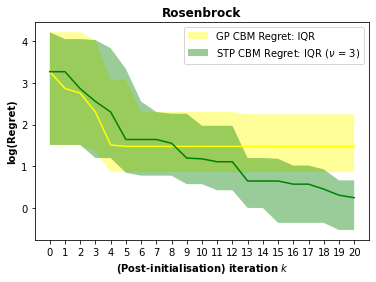

In [95]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_gp, color = 'yellow')
plt.plot(median_stp, color = 'green')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'yellow', alpha=0.4, label='GP CBM Regret: IQR')
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'green', alpha=0.4, label='STP CBM Regret: IQR ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!
